In [33]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse

from jaxley_mech.synapses import GapJunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


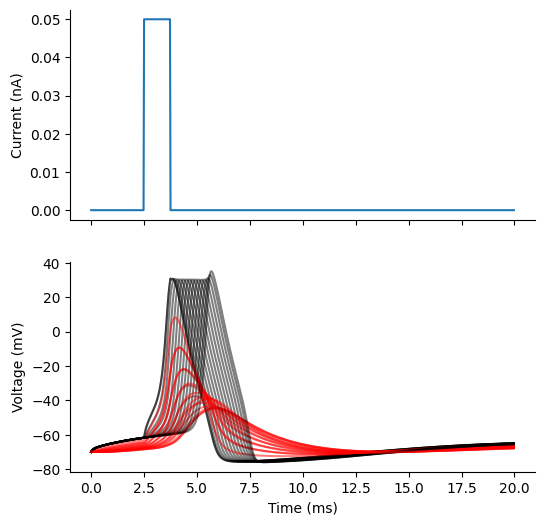

In [34]:
n_cells = 2
dt = 0.025
t_max = 20
gE = 20.0
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=16)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])

cell1 = network.cell([0])
cell2 = network.cell([1])
cell1.fully_connect(cell2, GapJunction())
network.GapJunction.set("gE", gE)

# Insert mechanisms
cell1.insert(HH())
cell2.insert(Leak())

network.delete_recordings()
for i in range(16):
    network.cell(0).branch(0).comp(i/16).record()
for i in range(16):
    network.cell(1).branch(0).comp(i/16).record()

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = network.cell(0).branch(0).comp(0).data_stimulate(inp_current, data_stimuli=data_stimuli)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
for i in range(16):
    ax[1].plot(time, v[i, :-1], color="black", alpha=0.5)
    ax[1].plot(time, v[i + 16, :-1], color="red", alpha=0.5)

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

### Using Implicit Euler

If I understood correctly, there was a concern that gap junctions would make the system too stiff, so there would be a chance that the implicit Euler method would return a different (more accurate) result.

Increasing `gE` does in fact make the forward Euler integration unstable while the backward Euler method continues to manage. However, for a coupling constant unreasonably high, the backward Euler integration also becomes unstable.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


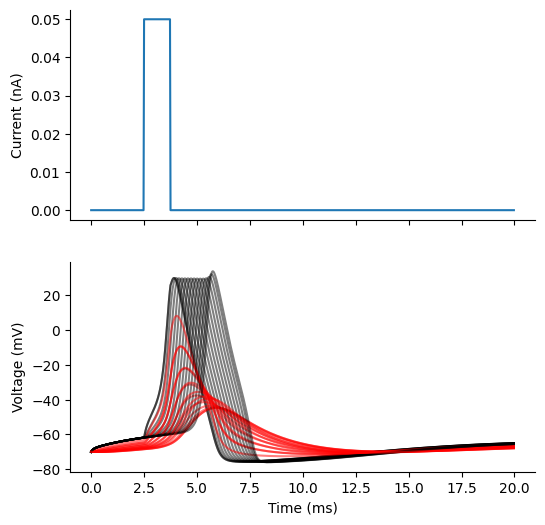

In [35]:
v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
for i in range(16):
    ax[1].plot(time, v[i, :-1], color="black", alpha=0.5)
    ax[1].plot(time, v[i + 16, :-1], color="red", alpha=0.5)

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();